### Importing Machine Learning Libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


### Reads an Excel file for performing classification

In [56]:
df = pd.read_excel("/home/kushal/Documents/projects/tf-idf-implementation/data/ConcatenatedDigitalAdData.xlsx")


### Creating a new column in the DataFrame called "TitleandDesc" by concatenating the values of the "title" and "Job_Description" columns

In [57]:
df["TitleandDesc"] = df["title"] + df["Job_Description"]

In [58]:
df["TitleandDesc"]

0       Commercial Painters needed ASAP at our Dallas/...
1       Nightclub Jobs -Model/Servers- Cash Daily,Look...
2       Nightclub Jobs -Model Servers- Cash Daily,* Mo...
3       PRINTING - 1st shift,CDL Class A full time loc...
4       Admin Assistant,Necesito personal de limpieza ...
                              ...                        
1536    Price Quoting AnalystElectronics company in Ca...
1537    Conltoller/Office Manager at Exciting CompanyR...
1538    Accounting & Tax ProfessionalCPA firm is hirin...
1539    Licensed Life and Health agenthttps://team.inv...
1540    REMCO NOW HIRING $2,600-$3,000 + COMMISSIONS -...
Name: TitleandDesc, Length: 1541, dtype: object

### Cleaning and Preprocessing the data before further analysis

In [59]:
df.drop(['Index', 'title','url','Posted-Date', 'Job_Description'], axis=1, inplace=True)
df

,JobType,TitleandDesc
0,Jobs – Retail,Commercial Painters needed ASAP at our Dallas/...
1,Jobs – Retail,"Nightclub Jobs -Model/Servers- Cash Daily,Look..."
2,Jobs – Retail,"Nightclub Jobs -Model Servers- Cash Daily,* Mo..."
3,Jobs – IT,"PRINTING - 1st shift,CDL Class A full time loc..."
4,Jobs – IT,"Admin Assistant,Necesito personal de limpieza ..."
...,...,...
1536,Banking,Price Quoting AnalystElectronics company in Ca...
1537,Banking,Conltoller/Office Manager at Exciting CompanyR...
1538,Banking,Accounting & Tax ProfessionalCPA firm is hirin...
1539,Banking,Licensed Life and Health agenthttps://team.inv...


In [60]:
first_column = df.pop('TitleandDesc')
df.insert(0, 'TitleandDesc', first_column)

In [61]:
df.shape

(1541, 2)

In [62]:
total = df['TitleandDesc'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [63]:
# df.head(15)

### Displaying the class 'JobType'

In [64]:
pd.DataFrame(df.JobType.unique()).values

array([['Jobs – Retail'],
       ['Jobs – IT'],
       ['Rent – Apartment'],
       ['Sell – House'],
       ['Banking']], dtype=object)

### Calculating the number of data belonging to the classes

In [65]:
from collections import Counter
Counter(df["JobType"])

Counter({'Jobs – Retail': 517,
         'Jobs – IT': 91,
         'Rent – Apartment': 135,
         'Sell – House': 607,
         'Banking': 191})

### Making ease to feed to Machine Learning
Categorical variables such as 'JobType' cannot be directly used in many machine learning algorithms, as they are typically designed to work with numerical data. In order to use the 'JobType' column in these algorithms, it needs to be converted to numerical form. One way to do this is through a process called factorization, which assigns a unique integer value to each unique category. This allows for the categorical data to be used in machine learning algorithms as numerical data.

Additionally, creating the dictionaries 'job_to_id' and 'id_to_job' allows for easy mapping between the original categorical values and the numerical values. This will be useful for interpreting the results of the model later on.

In [66]:
df['Job_Id'] = df['JobType'].factorize()[0]
job_id_df = df[['JobType', 'Job_Id']].drop_duplicates()


# Dictionaries for future use
job_to_id = dict(job_id_df.values)
id_to_job = dict(job_id_df[['Job_Id', 'JobType']].values)

# New dataframe
df

,TitleandDesc,JobType,Job_Id
0,Commercial Painters needed ASAP at our Dallas/...,Jobs – Retail,0
1,"Nightclub Jobs -Model/Servers- Cash Daily,Look...",Jobs – Retail,0
2,"Nightclub Jobs -Model Servers- Cash Daily,* Mo...",Jobs – Retail,0
3,"PRINTING - 1st shift,CDL Class A full time loc...",Jobs – IT,1
4,"Admin Assistant,Necesito personal de limpieza ...",Jobs – IT,1
...,...,...,...
1536,Price Quoting AnalystElectronics company in Ca...,Banking,4
1537,Conltoller/Office Manager at Exciting CompanyR...,Banking,4
1538,Accounting & Tax ProfessionalCPA firm is hirin...,Banking,4
1539,Licensed Life and Health agenthttps://team.inv...,Banking,4


### Checking for missiong values in Dataframe
**If there are no mising values, it returns '0'**

In [67]:
df.isnull().sum()

TitleandDesc    0
JobType         0
Job_Id          0
dtype: int64

### Distribution of different JobTypes in the dataset.


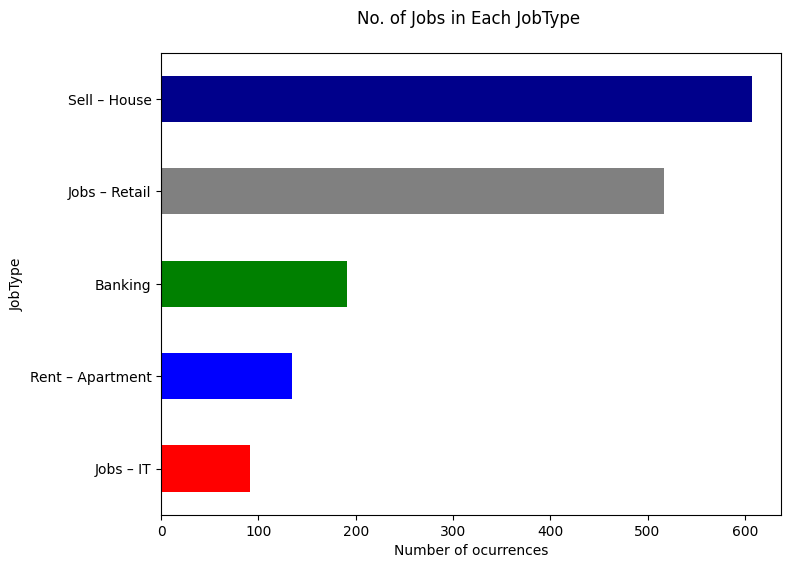

In [68]:
fig = plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'grey', 'darkblue']
df.groupby('JobType').TitleandDesc.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'No. of Jobs in Each JobType \n')
plt.xlabel('Number of ocurrences', fontsize = 10);

### Feature Extraction 
Using **TfidfVectorizer** from scikit-learn.

In [69]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df.TitleandDesc).toarray()

labels = df.Job_Id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1541 complaints is represented by 15335 features (TF-IDF score of unigrams and bigrams)


In [70]:
# features

In [71]:
# labels

### Generating Unigrams and Bigrams
Performing feature selection using chi-squared test on the Tf-Idf features and labels. It prints the top N correlated unigrams, and bigrams for each JobType.
This is done to improve the performance of text classification task.

In [72]:
N = 4
for JobType, Job_Id in sorted(job_to_id.items()):
    features_chi2 = chi2(features, labels == Job_Id)
    indices = np.argsort(features_chi2[0])
    
    vocab = {v: k for k, v in tfidf.vocabulary_.items()}
    feature_names = [vocab[i] for i in indices]   
     
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("\n==> %s:" %(JobType))
    
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))



==> Banking:
  * Most Correlated Unigrams are: quickbooks, bookkeeper, accountant, accounting
  * Most Correlated Bigrams are: bookkeeper job, assistant job, senior accountant, accountant job

==> Jobs – IT:
  * Most Correlated Unigrams are: docx, extensions, pdf, years0
  * Most Correlated Bigrams are: extensions supported0, jobs email, best matching, matching jobs

==> Jobs – Retail:
  * Most Correlated Unigrams are: truck, cdl, driver, drivers
  * Most Correlated Bigrams are: direct deposit, owner operators, class cdl, sign bonus

==> Rent – Apartment:
  * Most Correlated Unigrams are: 2022this, originator, rent, roommates
  * Most Correlated Bigrams are: room available, room room, room roommates, roommates available

==> Sell – House:
  * Most Correlated Unigrams are: floor, bedrooms, large, ny
  * Most Correlated Bigrams are: brooklyn ny, dining room, hardwood floors, living room


In [73]:
X = np.array(df["TitleandDesc"])
y = np.array(df["JobType"])

In [74]:
job_types = pd.DataFrame(df.JobType.unique()).values.tolist()
job_types


[['Jobs – Retail'],
 ['Jobs – IT'],
 ['Rent – Apartment'],
 ['Sell – House'],
 ['Banking']]

### Train Test Split
Splitting the data into training and testing sets for model evaluation

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

### OneVsRestClassifier 
The OneVsRestClassifier is a class in scikit-learn that allows for multi-label classification by training a binary classifier for each label separately, and then using these binary classifiers to make predictions for new instances. It is used for multi-class problems.


In [76]:
#pipeline of feature engineering and model
model = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])
#the class_weight="balanced" option tries to remove the biasedness of model towards majority sample


### Training the Text Classification Model on the training data

In [77]:
#fit model with training data
model.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced')))])

### Confusion Matrix
A confusion matrix is a table that is used to define the performance of a classification algorithm. It gives an idea of how well the algorithm is classifying the problem by comparing the predicted values with the true values in the test set.

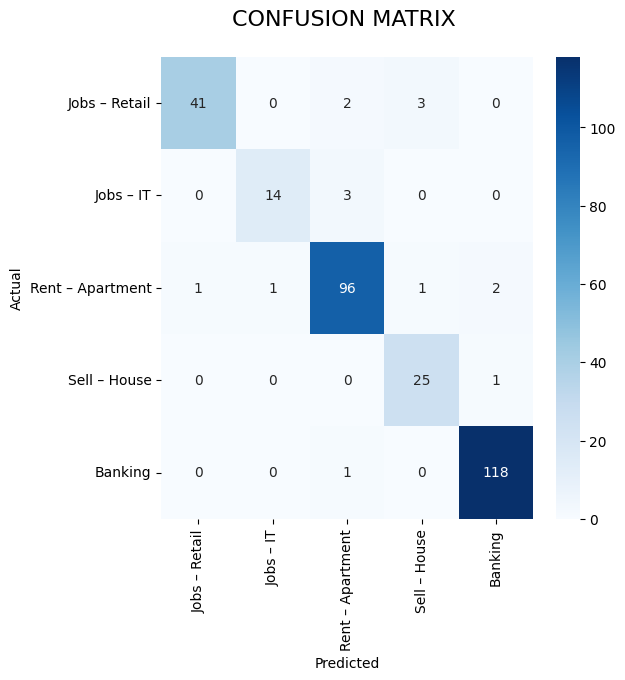

In [78]:
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    conf_mat, 
    annot=True, 
    cmap="Blues", 
    fmt='d',
    xticklabels=job_id_df.JobType.values, 
    yticklabels=job_id_df.JobType.values
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX \n", size=16);

### Classification Report
It is a summary of the performance of a classifier for a classification problem. It displays several evaluation metrics for each class, including precision, recall, f1-score and support. It is a text report that contains several evaluation metrics for each class and it helps to understand the performance of a classifier.


In [79]:
print('\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(
        y_test, 
        y_pred, 
        target_names = df['JobType'].unique()
    )
)

			CLASSIFICATIION METRICS

                  precision    recall  f1-score   support

   Jobs – Retail       0.98      0.89      0.93        46
       Jobs – IT       0.93      0.82      0.87        17
Rent – Apartment       0.94      0.95      0.95       101
    Sell – House       0.86      0.96      0.91        26
         Banking       0.98      0.99      0.98       119

        accuracy                           0.95       309
       macro avg       0.94      0.92      0.93       309
    weighted avg       0.95      0.95      0.95       309



### Save the model

In [80]:
import pickle
filename = '/home/kushal/Documents/projects/tf-idf-implementation/model/adv_model.sav'
# pickle.dump(model, open(filename, 'wb'))

### Load The Model

In [81]:
loaded_model = pickle.load(open(filename, 'rb'))

### Accuracy

In [82]:
result = loaded_model.score(X_test, y_test)
print(f"The Accuracy of the Classification is:  {round(result*100, 3)}%")

The Accuracy of the Classification is:  95.146%


### Sample Input and Testing The Model

In [83]:
job = input("Enter the text that we need to classify")
print(job)
model.predict([job])[0]

We are seeking a highly motivated Retail Sales Associate to join our team. The ideal candidate will have experience working in a retail environment and will be passionate about providing excellent customer service.


'Jobs – Retail'